In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks, regularizers, Input, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    Concatenate, Bidirectional, GlobalAveragePooling1D, Layer
)
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import BinaryFocalCrossentropy
from keras.regularizers import l2

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard  # Training callbacks


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


## Download NLTK assets

In [ ]:
# Download NLTK assets
import nltk
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## DEfine Constant Variables

In [ ]:
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 6
FEED_FORWARD_DIM = 1024
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 16 #32
EPOCHS = 10

## Load Datasets

In [ ]:
import os
os.listdir('./')

['.config', 'drive', 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/drive/MyDrive/Project/A Comprehensive Dataset for Automated Cyberbullying Detection.zip'
# Directory where you want to extract
extract_to = '/content/Cyberbullying/'

# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")


Extraction complete.


In [ ]:

# Path to the zip file
zip_path = '/content/drive/MyDrive/Project/A Comprehensive Dataset for Automated Cyberbullying Detection.zip'
# Directory where you want to extract
extract_to = '/content/Cyberbullying/'

# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")

In [ ]:
import pandas as pd

In [ ]:
# Load necessary CSV files
# Please update the file paths below to match the location of your files in Google Drive
cb_labels_df = pd.read_csv("/content/Cyberbullying/A Comprehensive Dataset for Automated Cyberbullying Detection/6. CB_Labels.csv")
users_df = pd.read_csv("/content/Cyberbullying/A Comprehensive Dataset for Automated Cyberbullying Detection/1. users_data.csv")
communication_df = pd.read_csv("/content/Cyberbullying/A Comprehensive Dataset for Automated Cyberbullying Detection/5. Communication_Data_Among_Users.csv")

In [ ]:
users_df

,UserID,Age,Gender,School Name,Grade
0,1,11,Others,School10,5
1,2,15,Male,School5,9
2,3,11,Male,School13,5
3,4,17,Male,School14,11
4,5,17,Male,School6,11
...,...,...,...,...,...
95,96,13,Male,School10,7
96,97,14,Others,School8,8
97,98,10,Others,School15,4
98,99,11,Others,School1,5


Correlation matrix for users_df:
          UserID       Age     Grade
UserID  1.000000 -0.155903 -0.155903
Age    -0.155903  1.000000  1.000000
Grade  -0.155903  1.000000  1.000000


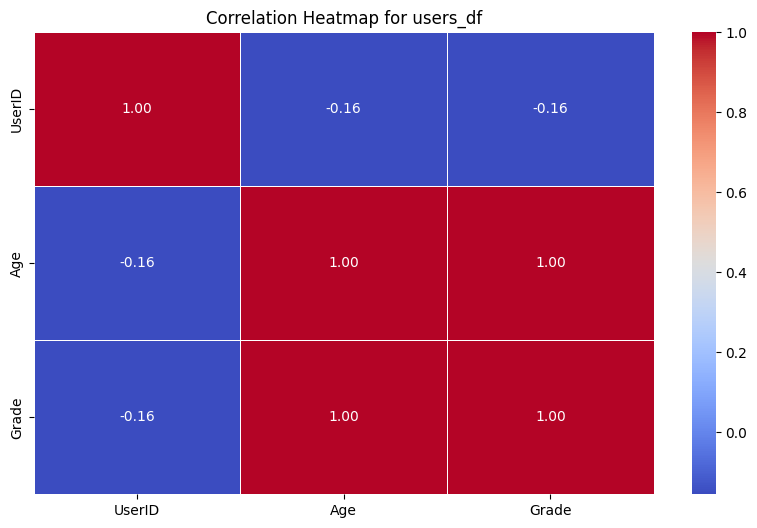

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

users_numeric = users_df.select_dtypes(include=['number'])
users_corr = users_numeric.corr()
print("Correlation matrix for users_df:")
print(users_corr)
plt.figure(figsize=(10, 6))
sns.heatmap(users_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for users_df')
plt.show()

In [ ]:
cb_labels_df.head()

,User1 ID,User2 ID,Total_messages,Aggressive_Count,Intent_to_Harm,Peerness,CB_Label
0,1,2,36,23,0.769444,0.500000,1
1,1,3,16,9,0.481250,0.766667,1
2,1,4,17,8,0.447794,0.366667,0
3,1,5,24,15,0.612500,0.366667,0
4,1,6,15,7,0.420833,0.433333,1


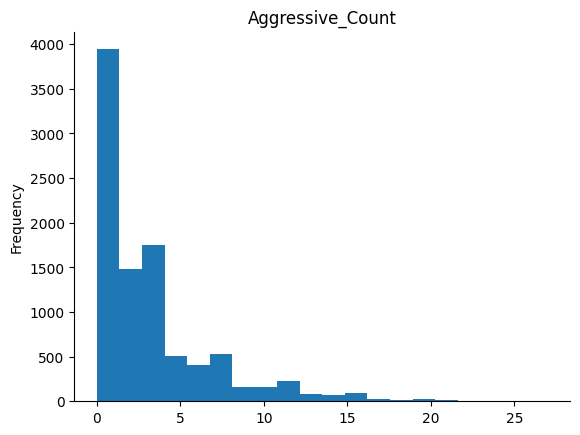

In [ ]:
# @title Aggressive_Count

from matplotlib import pyplot as plt
cb_labels_df['Aggressive_Count'].plot(kind='hist', bins=20, title='Aggressive_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
users_df.head()

,UserID,Age,Gender,School Name,Grade
0,1,11,Others,School10,5
1,2,15,Male,School5,9
2,3,11,Male,School13,5
3,4,17,Male,School14,11
4,5,17,Male,School6,11


## Merge Demographic and CB_Labels

In [ ]:
# Merge user demographic info into CB_Labels
merged_df = cb_labels_df.merge(users_df, how='left', left_on='User1 ID', right_on='UserID', suffixes=('', '_User1'))
merged_df = merged_df.merge(users_df, how='left', left_on='User2 ID', right_on='UserID', suffixes=('', '_User2'))
merged_df.drop(columns=['UserID', 'UserID_User2'], inplace=True)

In [ ]:
merged_df.head()

,User1 ID,User2 ID,Total_messages,Aggressive_Count,Intent_to_Harm,Peerness,CB_Label,Age,Gender,School Name,Grade,Age_User2,Gender_User2,School Name_User2,Grade_User2
0,1,2,36,23,0.769444,0.500000,1,11,Others,School10,5,15,Male,School5,9
1,1,3,16,9,0.481250,0.766667,1,11,Others,School10,5,11,Male,School13,5
2,1,4,17,8,0.447794,0.366667,0,11,Others,School10,5,17,Male,School14,11
3,1,5,24,15,0.612500,0.366667,0,11,Others,School10,5,17,Male,School6,11
4,1,6,15,7,0.420833,0.433333,1,11,Others,School10,5,16,Male,School12,10


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9511 entries, 0 to 9510
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   User1 ID           9511 non-null   int64  
 1   User2 ID           9511 non-null   int64  
 2   Total_messages     9511 non-null   int64  
 3   Aggressive_Count   9511 non-null   int64  
 4   Intent_to_Harm     9511 non-null   float64
 5   Peerness           4825 non-null   float64
 6   CB_Label           9511 non-null   int64  
 7   Age                9511 non-null   int64  
 8   Gender             9511 non-null   object 
 9   School Name        9511 non-null   object 
 10  Grade              9511 non-null   int64  
 11  Age_User2          9511 non-null   int64  
 12  Gender_User2       9511 non-null   object 
 13  School Name_User2  9511 non-null   object 
 14  Grade_User2        9511 non-null   int64  
dtypes: float64(2), int64(9), object(4)
memory usage: 1.1+ MB


Correlation matrix for merged_df:
                  User1 ID  User2 ID  Total_messages  Aggressive_Count  \
User1 ID          1.000000 -0.013985       -0.535505         -0.598036   
User2 ID         -0.013985  1.000000       -0.002944         -0.001294   
Total_messages   -0.535505 -0.002944        1.000000          0.881708   
Aggressive_Count -0.598036 -0.001294        0.881708          1.000000   
Intent_to_Harm   -0.571947  0.002850        0.717923          0.853553   
Peerness          0.012366  0.034397       -0.030649         -0.022142   
CB_Label         -0.416019  0.079925        0.556676          0.643575   
Age              -0.154555  0.003765        0.077691          0.088651   
Grade            -0.154555  0.003765        0.077691          0.088651   
Age_User2         0.002288 -0.154670       -0.009717         -0.015207   
Grade_User2       0.002288 -0.154670       -0.009717         -0.015207   

                  Intent_to_Harm  Peerness  CB_Label       Age     Grade  \
U

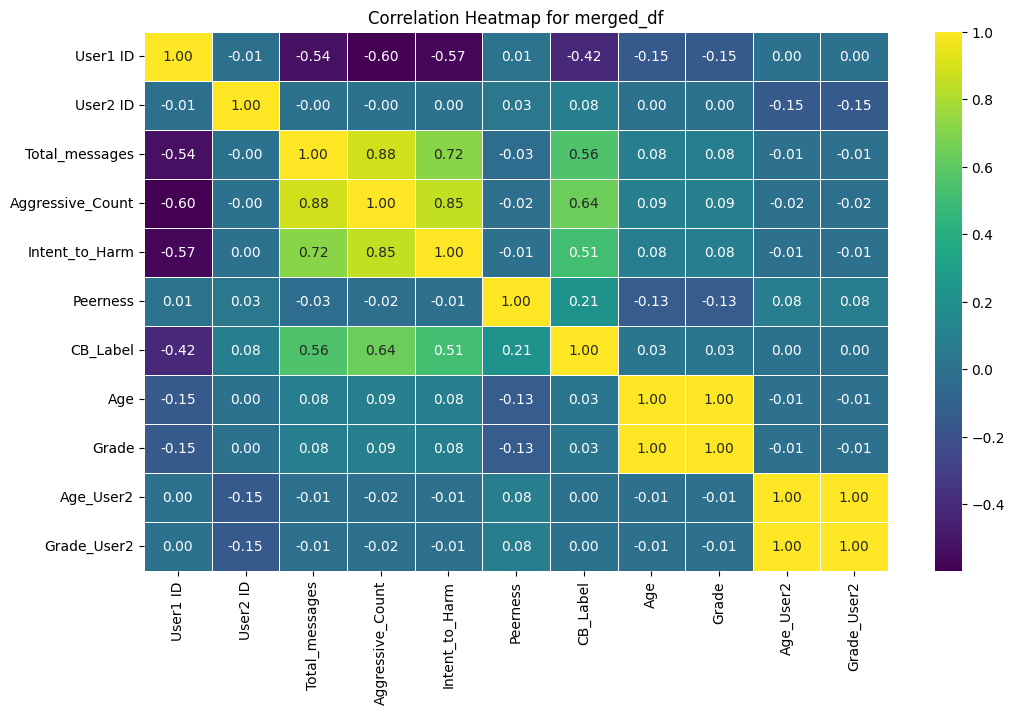

In [ ]:
merged_numeric = merged_df.select_dtypes(include=['number'])
merged_corr = merged_numeric.corr()
print("Correlation matrix for merged_df:")
print(merged_corr)
plt.figure(figsize=(12, 7))
sns.heatmap(merged_corr, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for merged_df')
plt.show()

### Remove emojis, special characters, URLs, newline, etc

In [ ]:
import string
# Remove emojis and special unicode characters
def strip_emoji(text):
    emoji_pattern = re.compile("["  # regex pattern for emojis and special symbols
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002500-\U00002BEF"  # Chinese characters
        u"\U00002702-\U000027B0"  # dingbats, shapes
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove newlines, links, non-ASCII characters, and most punctuation (keep /, \, .)
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    punctuation_to_remove = string.punctuation.replace('/', '').replace('\\', '').replace('.', '') + 'Ã±ã¼â»§'
    table = str.maketrans('', '', punctuation_to_remove)
    text = text.translate(table)
    return text

# Remove trailing hashtags and strip # or _ from words mid-sentence
def clean_hashtags(text):
    new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
    new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text))
    return new_text2

# Remove words containing special characters like $ and &
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Remove extra whitespace
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

# Remove date expressions and extra whitespace
def remove_dates_and_mult_spaces(text):
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '', text)
    text = re.sub(r'\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b', '', text)
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*[\s\-.,]*\d{1,2}[\s\-.,]*\d{4}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s\s+', ' ', text)
    return text.strip()

<>:37: SyntaxWarning: invalid escape sequence '\w'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\w'
<>:53: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2782977267.py:37: SyntaxWarning: invalid escape sequence '\w'
  new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
/tmp/ipython-input-2782977267.py:53: SyntaxWarning: invalid escape sequence '\s'
  return re.sub("\s\s+", " ", text)


In [ ]:
import re

communication_df['Message1'] = (communication_df['Message']
                     .apply(strip_emoji)
                     .apply(remove_dates_and_mult_spaces)
                     .apply(strip_all_entities)
                     .apply(clean_hashtags)
                     .apply(filter_chars)
                     )

In [ ]:
communication_df.head()

,Date,Time,User1 ID,User2 ID,Message,Label,Message1
0,2021-03-04,10:17,1,2,bye bye dear bajaj i got some better work to ...,1,bye bye dear bajaj i got some better work to d...
1,2022-01-24,04:27,1,2,Haha your so funny you sit on wikipedia all da...,1,haha your so funny you sit on wikipedia all da...
2,2021-02-03,02:19,1,2,My problem is people talking out of their asse...,1,my problem is people talking out of their asse...
3,2021-09-04,08:54,1,2,Article updated,0,article updated
4,2021-07-21,13:15,1,2,Well arent you phucking special Its easy to ha...,1,well arent you phucking special its easy to ha...


In [ ]:
df_comp = pd.DataFrame()

# Original text and its length
df_comp['pre-clean text'] = communication_df['Message']
df_comp['pre-clean len'] = communication_df['Message'].apply(lambda x: len(str(x).split()))

# Cleaned text and its length
df_comp['post-clean text'] = communication_df['Message1']
df_comp['post-clean len'] = communication_df['Message1'].apply(lambda x: len(str(x).split()))

df_comp.head(20)

,pre-clean text,pre-clean len,post-clean text,post-clean len
0,bye bye dear bajaj i got some better work to ...,17,bye bye dear bajaj i got some better work to d...,17
1,Haha your so funny you sit on wikipedia all da...,19,haha your so funny you sit on wikipedia all da...,19
2,My problem is people talking out of their asse...,36,my problem is people talking out of their asse...,36
3,Article updated,2,article updated,2
4,Well arent you phucking special Its easy to ha...,21,well arent you phucking special its easy to ha...,21
5,I THINK NAWLINWIKIS A HOMUNCULUS,5,i think nawlinwikis a homunculus,5
6,Forwarding Is it considered bad etiquette to f...,15,forwarding is it considered bad etiquette to f...,15
7,hehehe lol thanx blud i like anoyin ppl coz i ...,33,hehehe lol thanx blud i like anoyin ppl coz i ...,33
8,Hey jerk we may do a deal please let in peace ...,44,hey jerk we may do a deal please let in peace ...,44
9,WPBiography small living no class stub pri...,16,wpbiography small living no class stub priorit...,16


### Remove Stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords



# Custom stopword removal using a manually defined list
def remove_stopwords_one(sentence):
    """
    Removes a list of custom-defined stopwords.
    """
    # Manually defined list of common stopwords
    stopwords = ["abnormal", "a", "ive","im", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    # (full list truncated for brevity)

    sentence = sentence.lower()  # Convert to lowercase
    words = sentence.split()  # Split sentence into words
    no_words = [w for w in words if w not in stopwords]  # Remove stopwords
    sentence = " ".join(no_words)  # Reconstruct cleaned sentence

    return sentence

# Stopword removal using NLTK's standard stopwords list
def remove_stopwords(sentence):
    """
    Removes stopwords using NLTK's predefined English stopwords list.
    """
    stop_words = set(stopwords.words('english'))  # Load NLTK stopwords
    sentence = sentence.lower()  # Convert to lowercase
    words = sentence.split()  # Tokenize sentence
    no_words = [w for w in words if w not in stop_words]  # Remove stopwords
    sentence = " ".join(no_words)  # Rejoin words

    return sentence

In [ ]:
communication_df['Message2'] = (communication_df['Message1'].apply(remove_stopwords_one)
                              .apply(remove_stopwords))

In [ ]:
df_comp = pd.DataFrame()

# Original text and its length
df_comp['pre-clean text'] = communication_df['Message1']
df_comp['pre-clean len'] = communication_df['Message1'].apply(lambda x: len(str(x).split()))

# Cleaned text and its length
df_comp['post-clean text'] = communication_df['Message2']
df_comp['post-clean len'] = communication_df['Message2'].apply(lambda x: len(str(x).split()))

df_comp.head(20)

,pre-clean text,pre-clean len,post-clean text,post-clean len
0,bye bye dear bajaj i got some better work to d...,17,bye bye dear bajaj got better work watching ur...,12
1,haha your so funny you sit on wikipedia all da...,19,haha funny sit wikipedia day making sure every...,11
2,my problem is people talking out of their asse...,36,problem people talking asses fault people stup...,16
3,article updated,2,article updated,2
4,well arent you phucking special its easy to ha...,21,well arent phucking special easy things still ...,11
5,i think nawlinwikis a homunculus,5,think nawlinwikis homunculus,3
6,forwarding is it considered bad etiquette to f...,15,forwarding considered bad etiquette forward em...,10
7,hehehe lol thanx blud i like anoyin ppl coz i ...,33,hehehe lol thanx blud like anoyin ppl coz hav ...,24
8,hey jerk we may do a deal please let in peace ...,44,hey jerk may deal please let peace articles ca...,27
9,wpbiography small living no class stub priorit...,16,wpbiography small living class stub priority l...,15


### Lametization

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenize the input text into individual words
    word_list = nltk.word_tokenize(text)

    # Apply lemmatization to each word and rejoin into a sentence
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

    return lemmatized_output

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
communication_df['Message3'] = communication_df['Message2'].apply(lemmatize_text)

In [ ]:
df_comp = pd.DataFrame()

# Original text and its length
df_comp['pre-clean text'] = communication_df['Message2']
df_comp['pre-clean len'] = communication_df['Message2'].apply(lambda x: len(str(x).split()))

# Cleaned text and its length
df_comp['post-clean text'] = communication_df['Message3']
df_comp['post-clean len'] = communication_df['Message3'].apply(lambda x: len(str(x).split()))

df_comp.head(20)

,pre-clean text,pre-clean len,post-clean text,post-clean len
0,bye bye dear bajaj got better work watching ur...,12,bye bye dear bajaj got better work watching ur...,12
1,haha funny sit wikipedia day making sure every...,11,haha funny sit wikipedia day making sure every...,11
2,problem people talking asses fault people stup...,16,problem people talking ass fault people stupid...,16
3,article updated,2,article updated,2
4,well arent phucking special easy things still ...,11,well arent phucking special easy thing still l...,11
5,think nawlinwikis homunculus,3,think nawlinwikis homunculus,3
6,forwarding considered bad etiquette forward em...,10,forwarding considered bad etiquette forward em...,10
7,hehehe lol thanx blud like anoyin ppl coz hav ...,24,hehehe lol thanx blud like anoyin ppl coz hav ...,24
8,hey jerk may deal please let peace articles ca...,27,hey jerk may deal please let peace article car...,27
9,wpbiography small living class stub priority l...,15,wpbiography small living class stub priority l...,15


In [ ]:
communication_df.head()

,Date,Time,User1 ID,User2 ID,Message,Label,Message1,Message2,Message3
0,2021-03-04,10:17,1,2,bye bye dear bajaj i got some better work to ...,1,bye bye dear bajaj i got some better work to d...,bye bye dear bajaj got better work watching ur...,bye bye dear bajaj got better work watching ur...
1,2022-01-24,04:27,1,2,Haha your so funny you sit on wikipedia all da...,1,haha your so funny you sit on wikipedia all da...,haha funny sit wikipedia day making sure every...,haha funny sit wikipedia day making sure every...
2,2021-02-03,02:19,1,2,My problem is people talking out of their asse...,1,my problem is people talking out of their asse...,problem people talking asses fault people stup...,problem people talking ass fault people stupid...
3,2021-09-04,08:54,1,2,Article updated,0,article updated,article updated,article updated
4,2021-07-21,13:15,1,2,Well arent you phucking special Its easy to ha...,1,well arent you phucking special its easy to ha...,well arent phucking special easy things still ...,well arent phucking special easy thing still l...


In [ ]:
communication_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90356 entries, 0 to 90355
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      90356 non-null  object
 1   Time      90356 non-null  object
 2   User1 ID  90356 non-null  int64 
 3   User2 ID  90356 non-null  int64 
 4   Message   90356 non-null  object
 5   Label     90356 non-null  int64 
 6   Message1  90356 non-null  object
 7   Message2  90356 non-null  object
 8   Message3  90356 non-null  object
dtypes: int64(3), object(6)
memory usage: 6.2+ MB


### Merge required columns

In [ ]:
combined_df = pd.merge(communication_df, cb_labels_df[['User1 ID', 'User2 ID','Total_messages','Aggressive_Count', 'CB_Label','Intent_to_Harm']], on=['User1 ID', 'User2 ID'], how='inner')

In [ ]:
combined_df.tail()

,Date,Time,User1 ID,User2 ID,Message,Label,Message1,Message2,Message3,Total_messages,Aggressive_Count,CB_Label,Intent_to_Harm
90351,2021-11-21,11:55,100,98,No youre right it was a lame idea,0,no youre right it was a lame idea,youre right lame idea,youre right lame idea,6,0,0,0.075
90352,2021-05-11,14:39,100,99,break stuff did you really break things when...,0,break stuff did you really break things when y...,break stuff really break things noticed name t...,break stuff really break thing noticed name ta...,4,0,0,0.050
90353,2021-11-17,18:47,100,99,Stifle You might like to consult this page,0,stifle you might like to consult this page,stifle might like consult page,stifle might like consult page,4,0,0,0.050
90354,2021-06-07,14:11,100,99,Since the admin has already blocked MOVE of th...,0,since the admin has already blocked move of th...,since admin already blocked move article thing...,since admin already blocked move article thing...,4,0,0,0.050
90355,2021-11-03,02:07,100,99,Ill apologize to terry but bear in mind that h...,0,ill apologize to terry but bear in mind that h...,ill apologize terry bear mind better shut quips,ill apologize terry bear mind better shut quip,4,0,0,0.050


In [ ]:
clean_com_df = combined_df[['User1 ID', 'User2 ID', 'Message3','Total_messages','Aggressive_Count','Intent_to_Harm', 'Label']]

In [ ]:
clean_com_df.head()

,User1 ID,User2 ID,Message3,Total_messages,Aggressive_Count,Intent_to_Harm,Label
0,1,2,bye bye dear bajaj got better work watching ur...,36,23,0.769444,1
1,1,2,haha funny sit wikipedia day making sure every...,36,23,0.769444,1
2,1,2,problem people talking ass fault people stupid...,36,23,0.769444,1
3,1,2,article updated,36,23,0.769444,0
4,1,2,well arent phucking special easy thing still l...,36,23,0.769444,1


### Compute 95th percentile length

/tmp/ipython-input-3757880592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_com_df['sentence_length'] = clean_com_df['Message3'].apply(lambda x: len(x.split()))


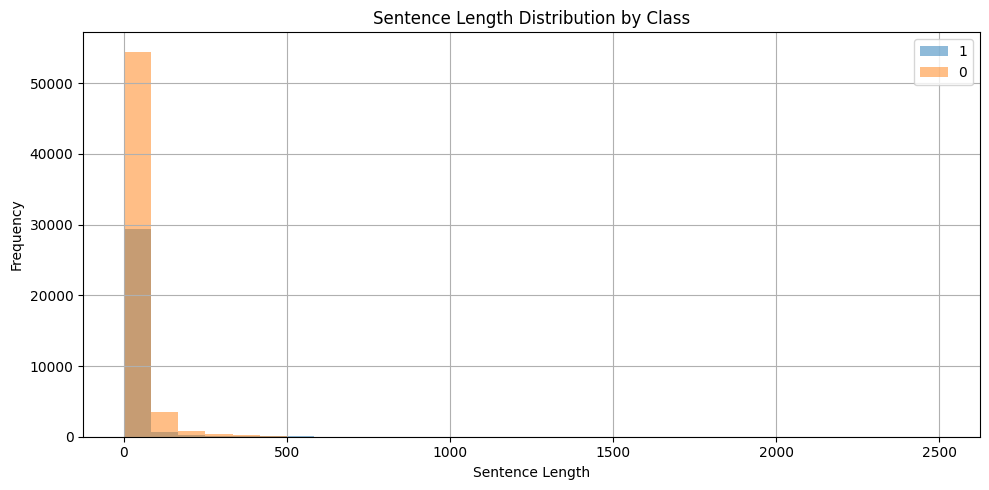

In [ ]:
# Compute sentence lengths
clean_com_df['sentence_length'] = clean_com_df['Message3'].apply(lambda x: len(x.split()))

# Basic statistics on sentence length
length_stats = clean_com_df["sentence_length"].describe()

# Plot distribution of sentence lengths by label
plt.figure(figsize=(10, 5))
for label in clean_com_df["Label"].unique():
    subset = clean_com_df[clean_com_df["Label"] == label]
    plt.hist(subset["sentence_length"], bins=30, alpha=0.5, label=label)
plt.title("Sentence Length Distribution by Class")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
lengths = clean_com_df["sentence_length"].values  # or whatever column tracks length

# Choose 95th percentile length
MAX_LEN = int(np.percentile(lengths, 95))
print(MAX_LEN)

106


Correlation matrix for clean_com_df:
                  User1 ID  User2 ID  Total_messages  Aggressive_Count  \
User1 ID          1.000000 -0.010723       -0.663403         -0.692328   
User2 ID         -0.010723  1.000000       -0.008528         -0.006692   
Total_messages   -0.663403 -0.008528        1.000000          0.890999   
Aggressive_Count -0.692328 -0.006692        0.890999          1.000000   
Intent_to_Harm   -0.724320 -0.004798        0.863464          0.949835   
Label            -0.195589  0.000582        0.138135          0.246922   
sentence_length   0.008578 -0.001892       -0.001651         -0.008415   
aggression_ratio -0.524856  0.001561        0.370681          0.662608   

                  Intent_to_Harm     Label  sentence_length  aggression_ratio  
User1 ID               -0.724320 -0.195589         0.008578         -0.524856  
User2 ID               -0.004798  0.000582        -0.001892          0.001561  
Total_messages          0.863464  0.138135        -0.001

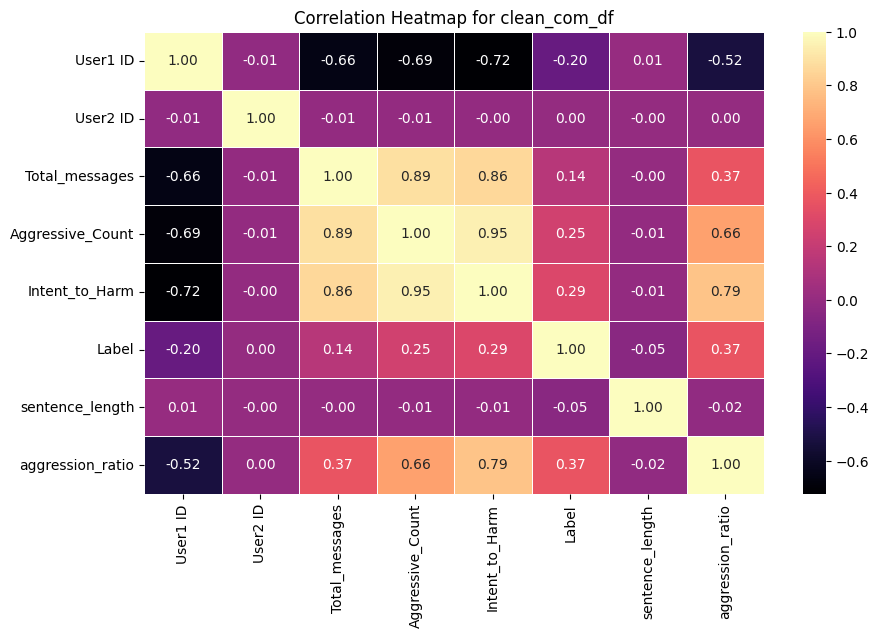

In [ ]:
clean_com_numeric = clean_com_df.select_dtypes(include=['number'])
clean_com_corr = clean_com_numeric.corr()
print("Correlation matrix for clean_com_df:")
print(clean_com_corr)
plt.figure(figsize=(10, 6))
sns.heatmap(clean_com_corr, annot=True, cmap='magma', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for clean_com_df')
plt.show()

### Tokenization

In [ ]:
from collections import Counter

# Tokenize the 'Message2' column (you can switch to any processed column)
tokenized_texts = clean_com_df['Message3'].astype(str).str.lower().str.split()

# Flatten the list of tokens
all_tokens = [token for sentence in tokenized_texts for token in sentence]
token_counts = Counter(all_tokens)

# Analyze token frequency
token_freqs = pd.DataFrame(token_counts.items(), columns=['token', 'count']).sort_values(by='count', ascending=False)
token_freqs['cumulative'] = token_freqs['count'].cumsum()
token_freqs['coverage'] = token_freqs['cumulative'] / token_freqs['count'].sum()

# Suggest VOCAB_SIZE to cover 99% of tokens
VOCAB_SIZE = token_freqs[token_freqs['coverage'] <= 0.99].shape[0]

# Suggest optimal BATCH_SIZE based on sentence length distribution
sentence_lengths = tokenized_texts.apply(len)
length_stats = sentence_lengths.describe()
BATCH_SIZE = 32 if length_stats['75%'] < 100 else 16  # heuristic

In [ ]:
BATCH_SIZE

32

In [ ]:
clean_com_df['Label'].value_counts()

,count
Label,
0,59579
1,30777


### Visulize distribution of labels

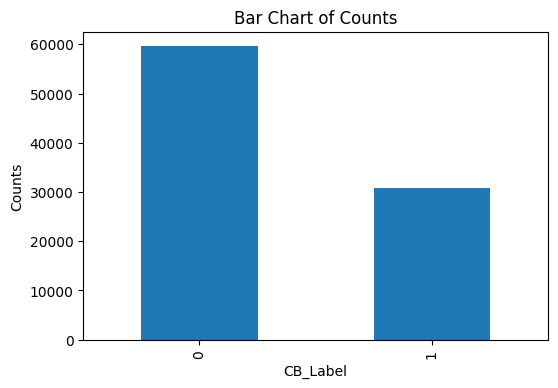

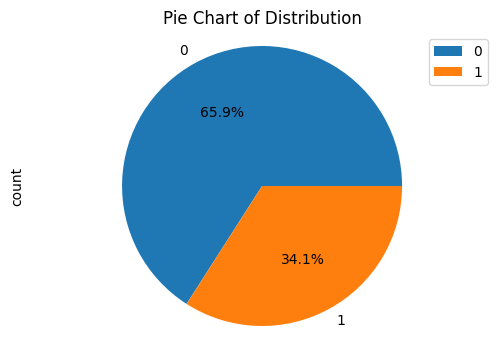

In [ ]:
import matplotlib.pyplot as plt

# Calculate the value counts of the 'category' column
category_counts = clean_com_df['Label'].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
category_counts.plot(kind='bar')
plt.xlabel('CB_Label')
plt.ylabel('Counts')
plt.title('Bar Chart of Counts')
plt.show()
print()

# Pie chart
plt.figure(figsize=(6, 4))
category_counts.plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Pie Chart of Distribution')

# Add legend
plt.legend()

plt.show()

In [ ]:
clean_com_df.head()

## Compute aggression_ratio

In [ ]:
#clean_com_df = communication_df[['User1 ID', 'User2 ID', 'Message2', 'Label']]
clean_com_df['aggression_ratio'] = clean_com_df['Aggressive_Count'] / clean_com_df['Total_messages'].replace(0, 1)

clean_com_df.head(100)

/tmp/ipython-input-2999425647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_com_df['aggression_ratio'] = clean_com_df['Aggressive_Count'] / clean_com_df['Total_messages'].replace(0, 1)


,User1 ID,User2 ID,Message3,Total_messages,Aggressive_Count,Intent_to_Harm,Label,sentence_length,aggression_ratio
0,1,2,bye bye dear bajaj got better work watching ur...,36,23,0.769444,1,12,0.638889
1,1,2,haha funny sit wikipedia day making sure every...,36,23,0.769444,1,11,0.638889
2,1,2,problem people talking ass fault people stupid...,36,23,0.769444,1,16,0.638889
3,1,2,article updated,36,23,0.769444,0,2,0.638889
4,1,2,well arent phucking special easy thing still l...,36,23,0.769444,1,11,0.638889
...,...,...,...,...,...,...,...,...,...
95,1,6,kb tk hamara inch ke bom ko sambhalkar rkha ja...,15,7,0.420833,1,10,0.466667
96,1,6,random place,15,7,0.420833,0,2,0.466667
97,1,6,youre stupid blithering retard currently sitti...,15,7,0.420833,1,16,0.466667
98,1,6,pleasure frustration likely agenda pusher pres...,15,7,0.420833,0,8,0.466667


In [ ]:
clean_com_df2 = clean_com_df[['Message3','Label', 'Total_messages',	'Aggressive_Count','Intent_to_Harm']] #User1 ID', 'User2 ID',

Correlation matrix:
                   Total_messages  Aggressive_Count  Intent_to_Harm
Total_messages          1.000000          0.890999        0.863464
Aggressive_Count        0.890999          1.000000        0.949835
Intent_to_Harm          0.863464          0.949835        1.000000


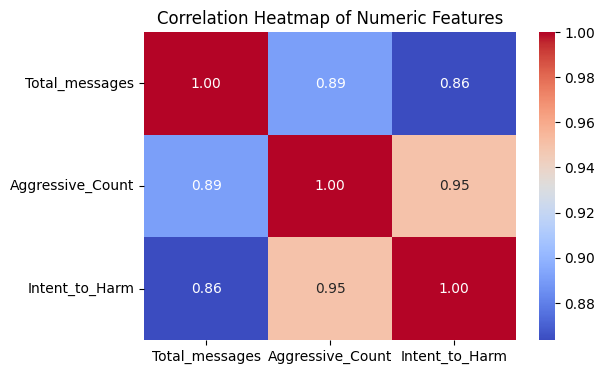

In [ ]:
# ================================
# Correlation Analysis and Heatmap
# ================================
# Check the correlation between numeric features and visualize with a heatmap.
import seaborn as sns  # For heatmap visualization

# Compute the correlation matrix for numeric features
corr_matrix = clean_com_df2[['Total_messages', 'Aggressive_Count', 'Intent_to_Harm']].corr()

# Print the correlation matrix
print("Correlation matrix:\n", corr_matrix)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

### Normalize Numeric Features

In [ ]:
numeric_features = clean_com_df2[['Total_messages', 'Aggressive_Count','Intent_to_Harm']].fillna(0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(numeric_features)

In [ ]:
print(type(normalized_features))             # should be <class 'numpy.ndarray'>
print(normalized_features.shape)             # should be (n_samples, 2)
print(normalized_features[:5])               # view the first 5 normalized rows


<class 'numpy.ndarray'>
(90356, 3)
[[2.42174285 3.59817582 2.52079056]
 [2.42174285 3.59817582 2.52079056]
 [2.42174285 3.59817582 2.52079056]
 [2.42174285 3.59817582 2.52079056]
 [2.42174285 3.59817582 2.52079056]]


### Split Dataset

In [ ]:
# Function to pad punctuation with spaces for better tokenization
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)  # Add spaces around punctuation
    s = re.sub(" +", " ", s)  # Replace multiple spaces with one
    return s

# Apply punctuation padding to each entry in the 'Message2' column
text_data = [pad_punctuation(x) for x in clean_com_df2['Message3']]

# Apply corrected mapping to labels
labels = clean_com_df2['Label']

In [ ]:
# Efficient conversion
text_data = np.array(text_data, dtype=object)  # Prevents crash
labels = np.array(labels)

# Only do this if not already an array
# normalized_features = np.array(normalized_features)

# Get split indices once and use them for all
indices = np.arange(len(text_data))
train_idx, val_idx = train_test_split(indices, test_size=0.3, random_state=42)

# Apply splits
text_train, text_val = text_data[train_idx], text_data[val_idx]
label_train, label_val = labels[train_idx], labels[val_idx]
numeric_train, numeric_val = normalized_features[train_idx], normalized_features[val_idx]


In [ ]:
BATCH_SIZE = 512

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    ({"text": text_train, "numeric": numeric_train}, label_train)
).batch(BATCH_SIZE).shuffle(1000)

val_ds = tf.data.Dataset.from_tensor_slices(
    ({"text": text_val, "numeric": numeric_val}, label_val)
).batch(BATCH_SIZE)


In [ ]:
# Convert to pandas Series to use .isnull()
text_data_series = pd.Series(labels)

print("NaN values in text_data:", text_data_series.isnull().sum())

NaN values in text_data: 0


In [ ]:
train_ds

<_ShuffleDataset element_spec=({'text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'numeric': TensorSpec(shape=(None, 3), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_ds

<_BatchDataset element_spec=({'text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'numeric': TensorSpec(shape=(None, 3), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Text Vectorization

In [ ]:
# Create a TextVectorization layer to convert text into integer sequences
vectorize_layer = layers.TextVectorization(
    standardize="lower",            # Convert all text to lowercase
    max_tokens=VOCAB_SIZE,          # Limit vocabulary size
    output_mode="int",              # Output as integer token IDs
    output_sequence_length=MAX_LEN  # Pad/truncate all sequences to fixed length
)

# Prepare a dataset containing only the text (exclude labels)
#text_only_train_ds = train_ds.map(lambda x, y: x)
text_only_train_ds = train_ds.map(lambda x, y: x["text"])


# Adapt the vectorization layer to learn the vocabulary from the training data
vectorize_layer.adapt(text_only_train_ds)

# Retrieve the vocabulary learned from training data
vocab = vectorize_layer.get_vocabulary()

### Define Model

In [ ]:
def prepare_inputs(inputs, labels):
    tokenized_text = vectorize_layer(inputs["text"])  # ✅ extract and vectorize text only
    return {"text": tokenized_text, "numeric": inputs["numeric"]}, labels


# Apply the function to transform both training and validation datasets
train_ds = train_ds.map(prepare_inputs)
val_ds = val_ds.map(prepare_inputs)

# Retrieve and print one example pair (tokenized input and corresponding label)
example_input_output = train_ds.take(1).get_single_element()

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.3, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(thresholds=self.threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=self.threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + 1e-7))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [ ]:
class_weight_dict = {0: 1.0, 1: 3.0}

In [ ]:
#def get_callbacks(monitor_metric="val_f1_score", mode="max", patience=30, project_path="/kaggle/working/", threshold=None):
def get_callbacks(monitor_metric="val_f1_score", mode="max", patience=5, project_path="/content/drive/MyDrive/Project/"):
    """
    Returns a dictionary of standard Keras callbacks with customizable monitoring metric.

    Args:
        monitor_metric (str): Metric to monitor (e.g., 'val_loss', 'val_f1_score', 'val_recall_1').
        mode (str): 'max' to maximize (F1, recall) or 'min' to minimize (loss).
        patience (int): Number of epochs with no improvement before stopping or reducing LR.
        project_path (str): Base directory to store checkpoints and logs.

    Returns:
        dict: Dictionary of callbacks.
    """

    checkpoint_path = os.path.join(project_path, "checkpoint", "checkpoint.weights.h5")
    log_dir = os.path.join(project_path, "logs")

    callbacks = {
        "checkpoint": ModelCheckpoint(
            filepath=checkpoint_path,
            monitor=monitor_metric,
            mode=mode,
            save_best_only=True,
            save_weights_only=True,
            save_freq="epoch",
            verbose=1
        ),
        "early_stop": EarlyStopping(
            monitor=monitor_metric,
            mode=mode,
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        "lr_scheduler": ReduceLROnPlateau(
            monitor=monitor_metric,
            mode=mode,
            factor=0.2,
            patience=patience,
            min_lr=1e-6,
            verbose=1
        ),
        "tensorboard": TensorBoard(log_dir=log_dir)
    }


    return callbacks

In [ ]:
# Set your metric target here
callbacks_dict = get_callbacks(monitor_metric="val_f1_score", mode="max")

**LSTM**

In [ ]:
# Input layers
text_input = Input(shape=(MAX_LEN,), dtype=tf.int32, name="text")
numeric_input = Input(shape=(3,), dtype=tf.float32, name="numeric")  # 2 numeric features

# Embedding layer
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN)(text_input)

# LSTM processing
x = LSTM(128, return_sequences=False)(embedding)
x = Dropout(0.3)(x)

# Concatenate with numeric features
x = Concatenate()([x, numeric_input])

# Fully connected layers
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

# Define the model
lstm_model = Model(inputs={"text": text_input, "numeric": numeric_input}, outputs=output)

from keras.losses import BinaryFocalCrossentropy

lstm_model.compile(
    optimizer="adam",
    loss=BinaryFocalCrossentropy(gamma=2.0),
    metrics=[
        F1Score(threshold=0.3),
        tf.keras.metrics.Precision(thresholds=0.3),
        tf.keras.metrics.Recall(thresholds=0.3)
    ]
)

lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 106)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 106, 256)  │ 29,720,320 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 128)       │    197,120 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 131)       │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ numeric[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,448 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         65 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,925,953 (114.16 MB)

 Trainable params: 29,925,953 (114.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 30

In [ ]:
history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=list(callbacks_dict.values())
)


Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - f1_score: 0.5096 - loss: 0.2615 - precision_11: 0.3419 - recall_11: 1.0000
Epoch 1: val_f1_score improved from -inf to 0.50869, saving model to /content/drive/MyDrive/Project/checkpoint/checkpoint.weights.h5
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - f1_score: 0.5096 - loss: 0.2614 - precision_11: 0.3419 - recall_11: 1.0000 - val_f1_score: 0.5087 - val_loss: 0.1718 - val_precision_11: 0.3411 - val_recall_11: 1.0000 - learning_rate: 0.0010
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - f1_score: 0.5172 - loss: 0.2521 - precision_11: 0.3489 - recall_11: 0.9991
Epoch 2: val_f1_score improved from 0.50869 to 0.52651, saving model to /content/drive/MyDrive/Project/checkpoint/checkpoint.weights.h5
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - f1_score: 0.5173 - loss: 0.2521 - precision_11: 0.3490 - recall_11: 0.9991 - val_f1_score: 0.5265 - val_loss: 0.1655 - val_precision_11: 0.3574 - val_recall_11: 0.9992 - learning_rate: 0.

In [ ]:
# Get predictions (probabilities)
y_probs = lstm_model.predict(val_ds)
# Convert to class labels based on threshold (e.g., 0.3)
y_pred = (y_probs > 0.3).astype(int)


# Get corresponding true labels
y_true = []
for _, label in val_ds.unbatch():
    y_true.append(label.numpy())

y_true = np.array(y_true).astype(int)

print(classification_report(y_true, y_pred, target_names=["Non-Cyberbullying", "Cyberbullying"]))



53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
                   precision    recall  f1-score   support

Non-Cyberbullying       0.91      0.85      0.88     17920
    Cyberbullying       0.74      0.84      0.79      9187

         accuracy                           0.85     27107
        macro avg       0.83      0.84      0.83     27107
     weighted avg       0.85      0.85      0.85     27107



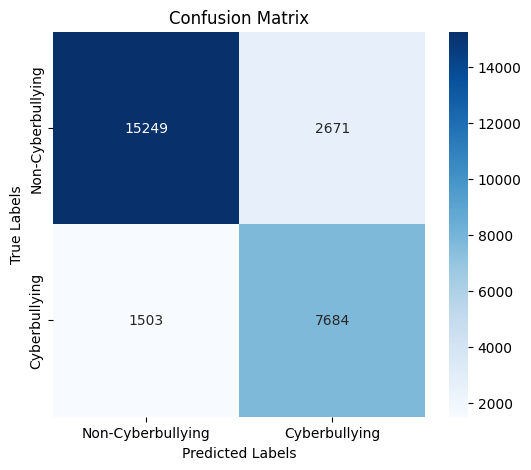

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))

labels = ['Non-Cyberbullying', 'Cyberbullying']  # replace with your actual class names

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.W = Dense(attention_dim, activation='tanh')  # learnable transformation
        self.V = Dense(1)  # projection to score

    def call(self, inputs):
        # inputs shape: (batch_size, sequence_length, hidden_dim)
        score = self.V(self.W(inputs))  # shape: (batch_size, sequence_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # shape: (batch_size, sequence_length, 1)

        context_vector = attention_weights * inputs  # shape: (batch_size, sequence_length, hidden_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # shape: (batch_size, hidden_dim)

        return context_vector  # final vector summarizing the sequence

**Bidirectional LSTM**

In [ ]:
# Inputs
text_input = Input(shape=(MAX_LEN,), dtype=tf.int32, name="text")
numeric_input = Input(shape=(3,), dtype=tf.float32, name="numeric")

# Embedding
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(text_input)

# BiLSTM
x = Bidirectional(LSTM(128, return_sequences=True))(embedding)

# Apply improved attention
context_vector = AttentionLayer(attention_dim=64)(x)

# Combine with numeric features
x = Concatenate()([context_vector, numeric_input])

# Dense layers
x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

# Build model
bilstm_attention_model = Model(inputs={"text": text_input, "numeric": numeric_input}, outputs=output)


In [ ]:
bilstm_attention_model.compile(
    optimizer="adam",
    loss=BinaryFocalCrossentropy(gamma=2.0),
    metrics=[
        F1Score(threshold=0.3),
        tf.keras.metrics.Precision(thresholds=0.3),
        tf.keras.metrics.Recall(thresholds=0.3)
    ]
)

bilstm_attention_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 106)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 106, 256)  │ 29,720,320 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 106, 256)  │    394,240 │ embedding_6[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 256)       │     16,513 │ bidirectional_1[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 259)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ numeric[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │     16,640 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,147,778 (115.00 MB)

 Trainable params: 30,147,778 (115.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = bilstm_attention_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=list(callbacks_dict.values())
)


Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - f1_score: 0.5357 - loss: 0.3012 - precision_13: 0.3665 - recall_13: 0.9974
Epoch 1: val_f1_score did not improve from 0.78641
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - f1_score: 0.5360 - loss: 0.3007 - precision_13: 0.3668 - recall_13: 0.9974 - val_f1_score: 0.5966 - val_loss: 0.1267 - val_precision_13: 0.4255 - val_recall_13: 0.9978 - learning_rate: 0.0010
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - f1_score: 0.7078 - loss: 0.1257 - precision_13: 0.5507 - recall_13: 0.9921
Epoch 2: val_f1_score did not improve from 0.78641
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - f1_score: 0.7078 - loss: 0.1257 - precision_13: 0.5508 - recall_13: 0.9921 - val_f1_score: 0.6943 - val_loss: 0.1036 - val_precision_13: 0.5361 - val_recall_13: 0.9849 - learning_rate: 0.0010
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - f1_score: 0.8201 - loss: 0.0748 - precision_13: 0.6977 - recall_13: 0.9949
Epoch 3: val_f1_score did not im

### Evaluate Model

In [ ]:
# Get predictions (probabilities)
y_probs = bilstm_attention_model.predict(val_ds)
# Convert to class labels based on threshold (e.g., 0.3)
y_pred = (y_probs > 0.3).astype(int)


# Get corresponding true labels
y_true = []
for _, label in val_ds.unbatch():
    y_true.append(label.numpy())

y_true = np.array(y_true).astype(int)


print(classification_report(y_true, y_pred, target_names=["Non-Cyberbullying", "Cyberbullying"]))

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
                   precision    recall  f1-score   support

Non-Cyberbullying       0.91      0.85      0.88     17920
    Cyberbullying       0.74      0.83      0.78      9187

         accuracy                           0.84     27107
        macro avg       0.82      0.84      0.83     27107
     weighted avg       0.85      0.84      0.84     27107



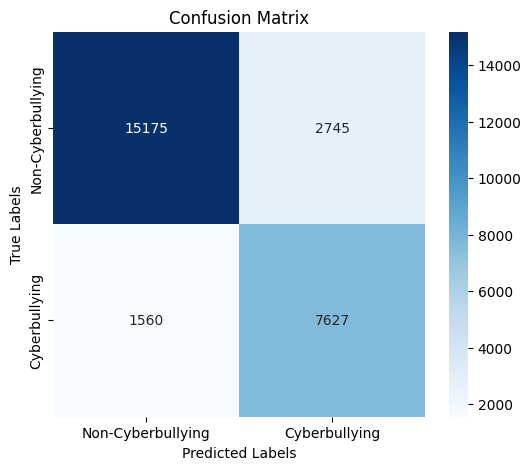

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))

labels = ['Non-Cyberbullying', 'Cyberbullying']  # replace with your actual class names

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
